## Hualien Earthquake Project

In [3]:
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
import scipy.signal as signal
from scipy.signal import stft
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len
import requests
# from libcomcat.search import search
# from libcomcat.dataframes import get_summary_data_frame
from obspy.taup import TauPyModel
from obspy.signal.trigger import classic_sta_lta
# import geopy.distance
import datetime
# import pygmt
# import rioxarray
from datetime import datetime, timedelta
import pytz
import geopandas as gpd

### Get a list of events from USGS

In [2]:
events = search(starttime = datetime(2024, 4, 1, 0, 0),
                endtime = datetime(2024, 4, 3, 0, 0),
                minmagnitude = 6.5)
event_df = get_summary_data_frame(events)
print("Return %s events" % len(events))

Return 1 events


In [3]:
event_df = event_df.sort_values(by=['time'], ascending=False)
event_df

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
0,us7000m9g4,2024-04-02 23:58:12.171,"15 km S of Hualien City, Taiwan",23.8353,121.5977,40,7.4,yellow,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,1388


In [4]:
this_event = event_df[event_df.id =='us7000m9g4']
t0 = this_event['time'].iloc[0]
t0_utc = UTCDateTime(t0)
this_event

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
0,us7000m9g4,2024-04-02 23:58:12.171,"15 km S of Hualien City, Taiwan",23.8353,121.5977,40,7.4,yellow,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,1388


In [5]:
# calculate arrival times
coords_1 = (this_event.latitude.to_numpy()[0], this_event.longitude.to_numpy()[0])
coords_2 = (47.6062, 122.3321)
dist_km = geopy.distance.geodesic(coords_1, coords_2).km
dist_deg = dist_km / 40075 * 360

In [6]:
model = TauPyModel(model='iasp91')
arrivals = model.get_travel_times(source_depth_in_km=this_event.depth.to_numpy()[0],
                                  distance_in_degree=dist_deg)
print(f'Distance = {dist_deg}, deg\nArrival time = {arrivals[0].time} s after source time.')
t0 = t0 + timedelta(seconds=arrivals[0].time) # Correct for travel time
t0 = t0 - timedelta(minutes=5) # Get one minute of data before the first arrival

Distance = 23.701172114144317, deg
Arrival time = 308.1278723198986 s after source time.


In [14]:
# # local time of the event
# # Define the UTC timestamp
# utc_timestamp = datetime.strptime("2024-04-02 23:58:12", "%Y-%m-%d %H:%M:%S")

# # Set the UTC timezone
# utc_timezone = pytz.timezone('UTC')

# # Localize the UTC timestamp
# utc_dt = utc_timezone.localize(utc_timestamp)

# # Convert to Taiwan local time
# taiwan_timezone = pytz.timezone('Asia/Taipei')
# taiwan_dt = utc_dt.astimezone(taiwan_timezone)

# print("Taiwan Local Time:", taiwan_dt)

NameError: name 'strptime' is not defined

### Seismology

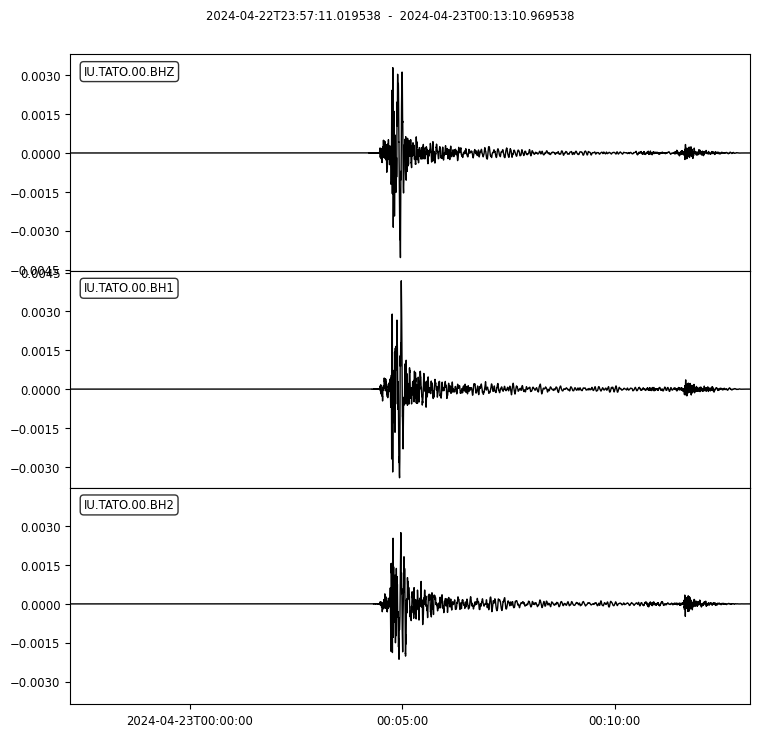

In [4]:
client = Client('IRIS')
time = UTCDateTime('2024-04-22T23:58:11')
starttime = time - 60
endtime = time + 60*15
net='IU'; sta='TATO'; loc='00'; chan='BH*'
Z = client.get_waveforms(net,sta,loc,chan, starttime, endtime, attach_response=True)
Z.remove_response(output='VEL')
Z.merge()
Z.detrend(type='linear')
Z.taper(max_percentage=0.05)
Z.plot();

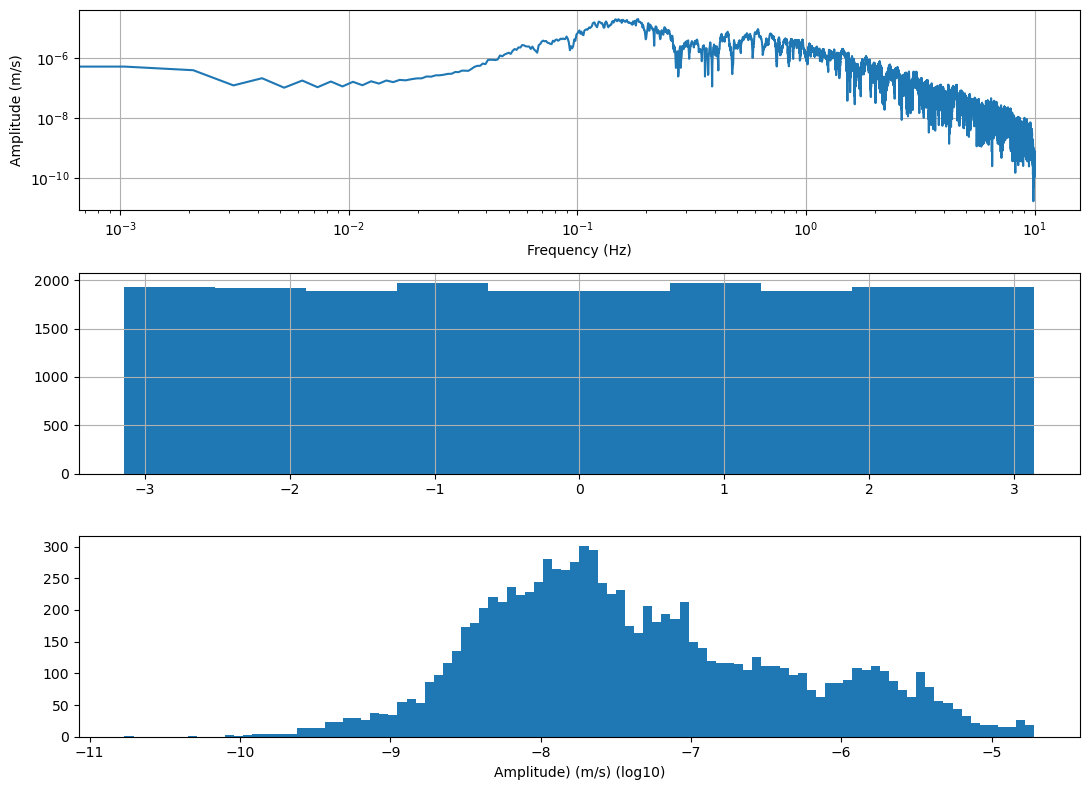

In [ ]:
npts = Z[0].stats.npts
Nfft = next_fast_len(int(Z[0].data.shape[0]))
freqVec = fftfreq(Nfft, d=Z[0].stats.delta)[:Nfft//2]
Zhat =  fft(Z[0].data, n=Nfft)

fig, ax = plt.subplots(3, 1, figsize=(11, 8))
ax[0].plot(freqVec, np.abs(Zhat[:Nfft//2])/Nfft)
ax[0].grid(True)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)');ax[0].set_ylabel('Amplitude (m/s)')
ax[1].hist(np.angle(Zhat))
ax[1].grid(True)
ax[2].hist(np.log10(np.abs(Zhat[:Nfft//2])/Nfft),100)
ax[2].set_xlabel('Amplitude) (m/s) (log10)')
plt.tight_layout()

0.00029237370747945763
1.831737492449356e-12


<function matplotlib.pyplot.show(close=None, block=None)>

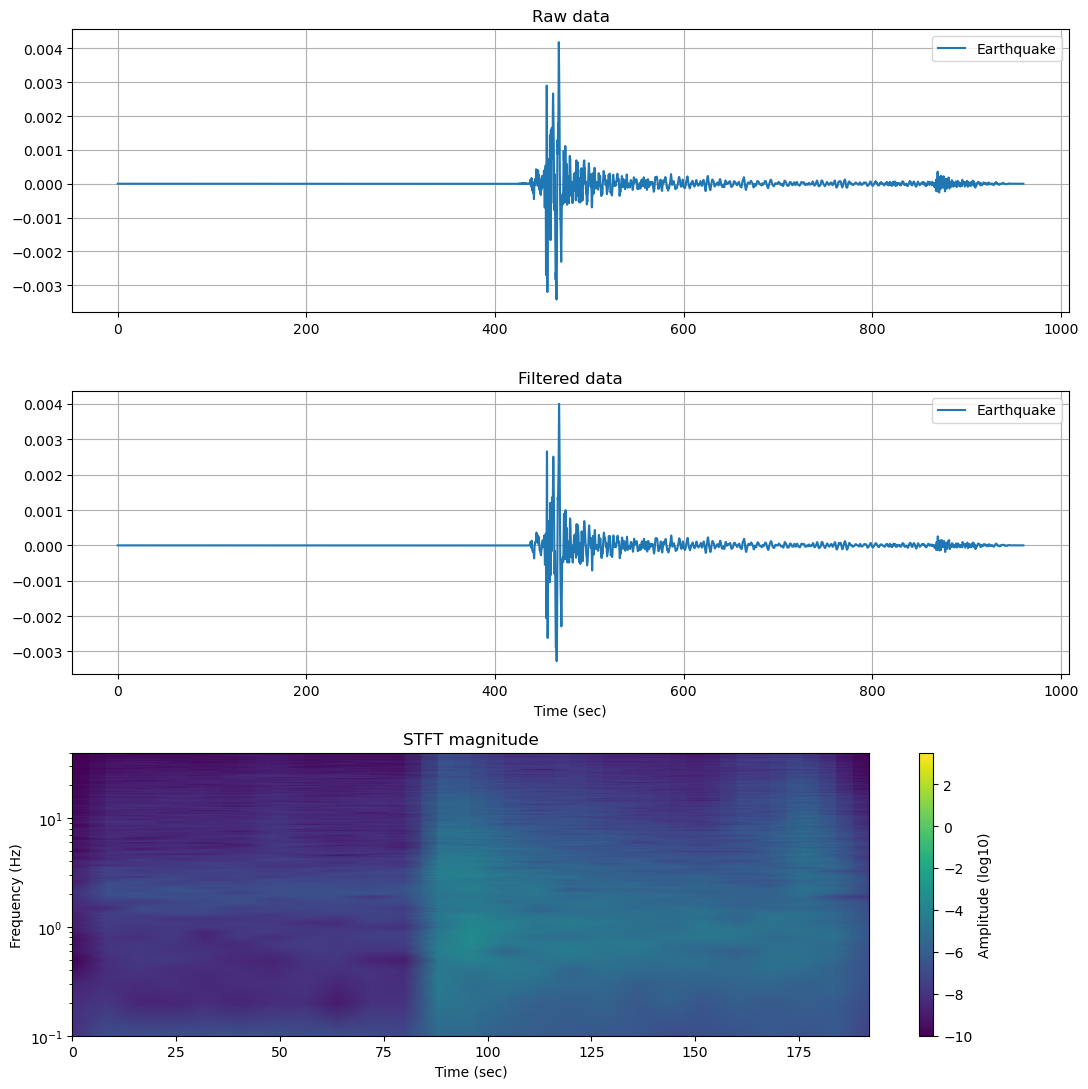

In [ ]:
# Z as an ObsPy trace object
fs = Z[0].stats.sampling_rate
Z_ = np.asarray(Z[0].data)

# filter the data
sos = signal.butter(2,[1./150.,1.],'bp', fs=fs,output='sos')
Zf = signal.sosfilt(sos,Z_)
t = np.arange(0, len(Z_)) / fs

# STFT
nperseg = 1000
f,t_,Zxx = stft(Z_, fs=100, nperseg=nperseg, noverlap=200)
print(np.max(np.max(np.abs(Zxx))))
print(np.min(np.min(np.abs(Zxx))))

# plotting
# raw data
fig, ax = plt.subplots(3,1,figsize = (11,11))
ax[0].plot(t,Z_); ax[0].grid(True)
ax[0].set_title('Raw data'); ax[0].legend(['Earthquake'])

# filtered data
ax[1].plot(t,Zf); ax[1].grid(True)
ax[1].set_title('Filtered data'); ax[1].legend(['Earthquake'])
ax[1].set_xlabel('Time (sec)')

# STFT magnitude
pcm = ax[2].pcolormesh(t_, f,np.log10(np.abs(Zxx)),vmin=-10,vmax=3.5,shading='gouraud')
ax[2].set_title('STFT magnitude')
ax[2].set_xlabel('Time (sec)'); ax[2].set_ylabel('Frequency (Hz)')
ax[2].set_yscale('log'); ax[2].set_ylim(0.1, 40)

cbar = fig.colorbar(pcm, ax=ax[2])
cbar.set_label('Amplitude (log10)')

plt.tight_layout()
plt.show


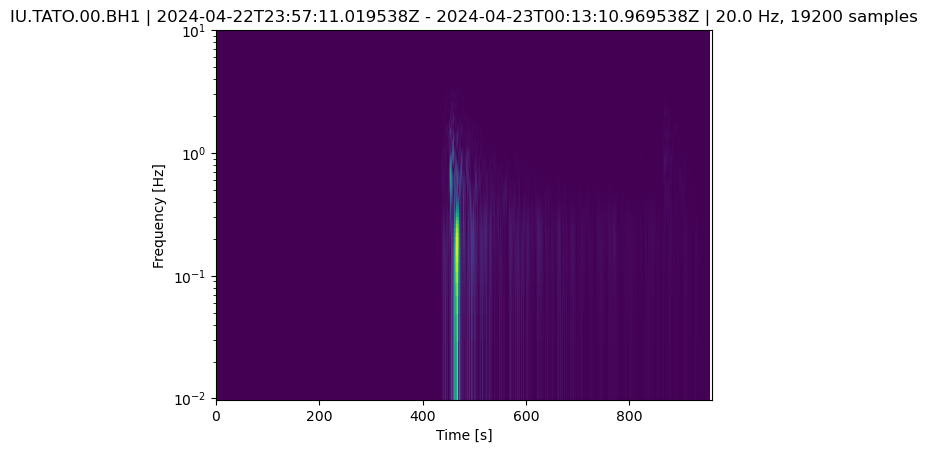

In [ ]:
Z[0].spectrogram(log=True)

In [ ]:
# Moment rate data from https://earthquake.usgs.gov/earthquakes/eventpage/us7000m9g4/finite-fault
url = 'https://raw.githubusercontent.com/Benz-Poobua/Hualien-Earthquake-analysis/47c400702cc341d69964b2ff2cd9a7f40726df5c/moment_rate.mr'
mr = pd.read_csv(url, header=None, delim_whitespace=True, names=['Time', 'MR'], skiprows=2)
print(mr)

       Time            MR
0      0.00  0.000000e+00
1      0.01  4.427200e+11
2      0.02  2.213400e+12
3      0.03  6.196800e+12
4      0.04  1.327600e+13
...     ...           ...
6896  68.96  0.000000e+00
6897  68.97  0.000000e+00
6898  68.98  0.000000e+00
6899  68.99  0.000000e+00
6900  69.00  0.000000e+00

[6901 rows x 2 columns]


Max moment rate =  1.1741e+19 Nm/s


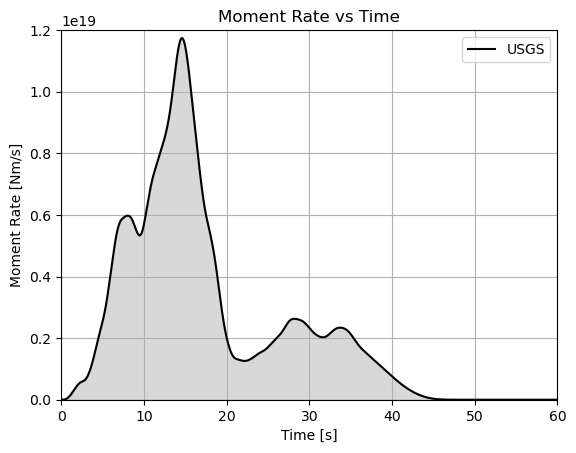

In [ ]:
fig = plt.figure()
max_MR = mr['MR'].max()
print('Max moment rate = ', max_MR, 'Nm/s')
plt.plot(mr.Time, mr.MR, label="USGS", c='black')
plt.xlim(0,60)
plt.ylim(0,1.2e19)
plt.fill_between(mr['Time'], mr['MR'], color='gray', alpha=0.3)  # Fill area under the curve with gray
plt.legend(loc="upper right")
plt.title('Moment Rate vs Time')
plt.xlabel("Time [s]")
plt.ylabel("Moment Rate [Nm/s]")
plt.grid(True)
plt.show()

In [ ]:
# Find the start time when mr.MR = 0
start_time_zero_MR = mr.loc[mr['MR'] == 0, 'Time'].iloc[1]
print("Start time when MR = 0:", start_time_zero_MR, "s")

Start time when MR = 0: 48.79 s


In [ ]:
# Calculate the time step (assuming uniform time intervals)
dt = mr.Time.diff().mean()
# Integrate the moment rate with respect to time using the trapezoidal rule
area_under_curve = np.trapz(mr.MR, dx=dt)
M0 = area_under_curve
print("M0:", M0, "Nm")


M0: 1.4392766715855176e+20 Nm


By the empirical relationship, $M_w = \frac{2}{3}(log_{10}{M_0}-9.1)$

In [ ]:
Mw = (2/3)*(np.log10(M0)-9.1)
print("Mw:", Mw)

Mw: 7.372096190812169


In [ ]:
# # URL to the GeoJSON file
# usgs_url = 'https://raw.githubusercontent.com/Benz-Poobua/Hualien-Earthquake-analysis/1b30a34ac6e12d01286c7c1f6e80c16048125c12/FFM.geojson'

# # Fetch the GeoJSON data
# response = requests.get(usgs_url)
# data = response.json()

# # Create a map centered at a location
# m = folium.Map(location=[23.75, 121.0], zoom_start=8)

# # Add each feature in the GeoJSON data to the map
# for feature in data['features']:
#     folium.GeoJson(feature).add_to(m)

# # Display the map
# m


In [ ]:
# GEM Global Active Faults Database (GEM GAF-DB) from Styron et al., 2020
active_faults_url = 'https://raw.githubusercontent.com/GEMScienceTools/gem-global-active-faults/master/gmt/gem_active_faults_harmonized.gmt'

# Bird, P. (2003) An updated digital model of plate boundaries, Geochemistry Geophysics Geosystems, 4(3), 1027, doi:10.1029/2001GC000252.
plate_boundaries_url = 'http://peterbird.name/oldFTP/PB2002/PB2002_boundaries.dig.txt'

# HUA3 gps station from http://geodesy.unr.edu/NGLStationPages/stations/HUA3.sta
gps_url = 'http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/HUA3.tenv3'

### Geodesy

In [ ]:
gps = pd.read_csv(gps_url, sep='\s+')

M 7.4 - 15 km S of Hualien City, Taiwan

- April 2, 2024: 2024.2521
- 23:58:12 (UTC)
- 23.835°N 121.598°E at 40.0 km depth



/var/folders/vn/yw43vwrj3nsglb002nc_3s6w0000gn/T/ipykernel_38223/4254573210.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


The Mw 7.4 Hualien earthquake has caused 
a westward motion of -2.22 cm 
a southward motion of 8.02 cm 
an uplift of 42.75 cm 
at the GPS station HUA3.


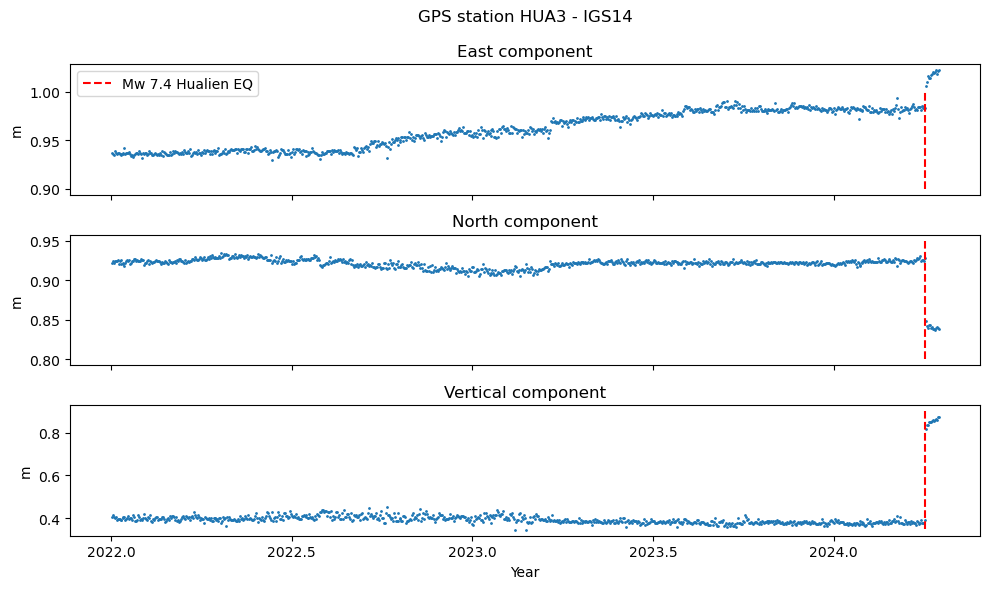

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(10,6), sharex = True)

recent_gps = gps[gps['yyyy.yyyy'] >= 2022.0]

event = 2024.2521
ax[0].set_title("GPS station HUA3 - IGS14\n\nEast component")
ax[0].plot(recent_gps['yyyy.yyyy'], recent_gps['__east(m)'], 'o', markersize=1)
ax[0].set_ylabel("m")
ax[0].vlines(x=event, ymin=0.9, ymax=1.0, label="Mw 7.4 Hualien EQ",
          colors='r', linestyles='dashed')
ax[0].legend(loc="upper left")

ax[1].set_title("North component")
ax[1].plot(recent_gps['yyyy.yyyy'], recent_gps['_north(m)'], 'o', markersize=1)
ax[1].set_ylabel("m")
ax[1].vlines(x=event, ymin=0.8, ymax=0.95, label="Mw 7.4 Hualien EQ",
          colors='r', linestyles='dashed')

ax[2].set_title("Vertical component")
ax[2].plot(recent_gps['yyyy.yyyy'], recent_gps['____up(m)'], 'o', markersize=1)
ax[2].set_ylabel("m")
ax[2].set_xlabel("Year")
ax[2].vlines(x=event, ymin=0.35, ymax=0.9, label="Mw 7.4 Hualien EQ",
          colors='r', linestyles='dashed')

fig.tight_layout()
fig.show()

print('''The Mw 7.4 Hualien earthquake has caused \na westward motion of {:.2f} cm \na southward motion of {:.2f} cm \nan uplift of {:.2f} cm \nat the GPS station {}.'''
      .format((gps["__east(m)"][gps[gps['YYMMMDD'].str.match('24APR02')].index[0]] 
             - gps["__east(m)"][gps[gps['YYMMMDD'].str.match('24APR03')].index[0]]) * 100,
              (gps["_north(m)"][gps[gps['YYMMMDD'].str.match('24APR02')].index[0]] 
             - gps["_north(m)"][gps[gps['YYMMMDD'].str.match('24APR03')].index[0]]) * 100,
              abs(gps["____up(m)"][gps[gps['YYMMMDD'].str.match('24APR02')].index[0]] 
             - gps["____up(m)"][gps[gps['YYMMMDD'].str.match('24APR03')].index[0]]) * 100,
              gps["site"].iloc[0]))

##

### Geospatial

In [ ]:
Taiwan_eq = pd.read_csv('http://raw.githubusercontent.com/Benz-Poobua/ESS_521/main/Taiwan_EQ_archives.csv')

In [ ]:
Taiwan_eq

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2024-04-23T17:12:14.997Z,23.7350,121.5936,7.881,4.0,mwr,44.0,88.0,0.436,0.66,...,2024-04-23T18:15:54.040Z,"26 km S of Hualien City, Taiwan",earthquake,2.90,5.194,0.069,20.0,reviewed,us,us
1,2024-04-23T16:02:21.245Z,24.0619,121.7117,7.473,4.9,mb,122.0,44.0,0.678,0.53,...,2024-04-23T17:00:10.040Z,"14 km NE of Hualien City, Taiwan",earthquake,2.73,3.524,0.053,118.0,reviewed,us,us
2,2024-04-23T12:40:51.668Z,23.7051,121.6597,10.000,4.4,mwr,70.0,39.0,0.456,0.68,...,2024-04-23T14:18:15.040Z,"30 km S of Hualien City, Taiwan",earthquake,5.24,1.651,0.089,12.0,reviewed,us,us
3,2024-04-23T05:08:05.896Z,23.7091,121.6223,10.000,4.7,mb,32.0,89.0,0.434,1.09,...,2024-04-23T05:42:31.040Z,"29 km S of Hualien City, Taiwan",earthquake,2.84,1.903,0.090,37.0,reviewed,us,us
4,2024-04-23T02:21:00.008Z,23.8333,121.6102,10.000,5.2,mwr,67.0,63.0,0.524,0.65,...,2024-04-23T23:47:21.223Z,"15 km S of Hualien City, Taiwan",earthquake,1.77,1.804,0.068,21.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1903,2000-01-21T01:36:24.900Z,24.0600,121.4100,7.600,4.5,ml,NaN,NaN,NaN,NaN,...,2014-11-07T01:09:21.123Z,Taiwan,earthquake,NaN,NaN,NaN,NaN,reviewed,tap,tap
1904,2000-01-20T17:42:11.810Z,23.4770,121.5260,33.000,4.7,mb,NaN,NaN,NaN,1.00,...,2014-11-07T01:09:21.067Z,"55 km S of Hualien City, Taiwan",earthquake,NaN,NaN,NaN,19.0,reviewed,us,us
1905,2000-01-12T03:17:23.670Z,23.2900,121.3620,33.000,3.9,mb,NaN,NaN,NaN,0.87,...,2014-11-07T01:09:19.174Z,"80 km SSW of Hualien City, Taiwan",earthquake,NaN,NaN,NaN,3.0,reviewed,us,us
1906,2000-01-03T22:59:14.830Z,24.0540,121.6240,10.000,NaN,NaN,NaN,NaN,NaN,1.19,...,2014-11-07T01:09:16.977Z,"8 km NNE of Hualien City, Taiwan",earthquake,NaN,NaN,NaN,NaN,reviewed,us,us


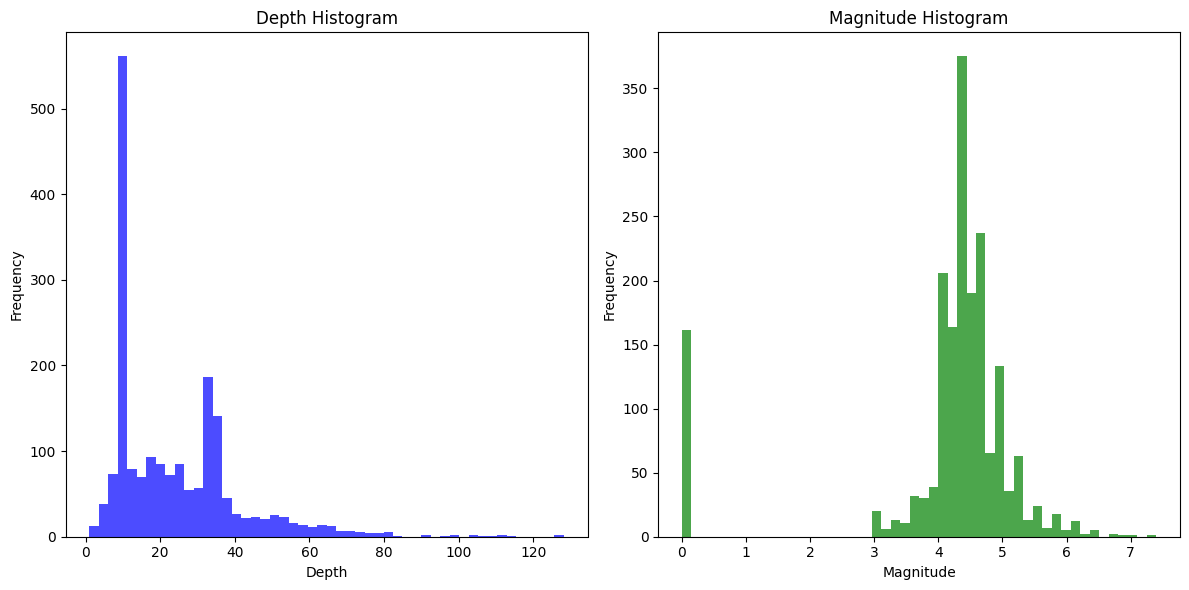

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for 'depth'
axes[0].hist(Taiwan_eq['depth'], bins=50, color='blue', alpha=0.7)
axes[0].set_title('Depth Histogram')
axes[0].set_xlabel('Depth')
axes[0].set_ylabel('Frequency')

# Histogram for 'mag'
axes[1].hist(Taiwan_eq['mag'], bins=50, color='green', alpha=0.7)
axes[1].set_title('Magnitude Histogram')
axes[1].set_xlabel('Magnitude')
axes[1].set_ylabel('Frequency')

# Show plot
plt.tight_layout()
plt.show()

grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from 120.5 to 120
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from 123.1 to 124
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 21.8 to 21
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 25.4 to 26


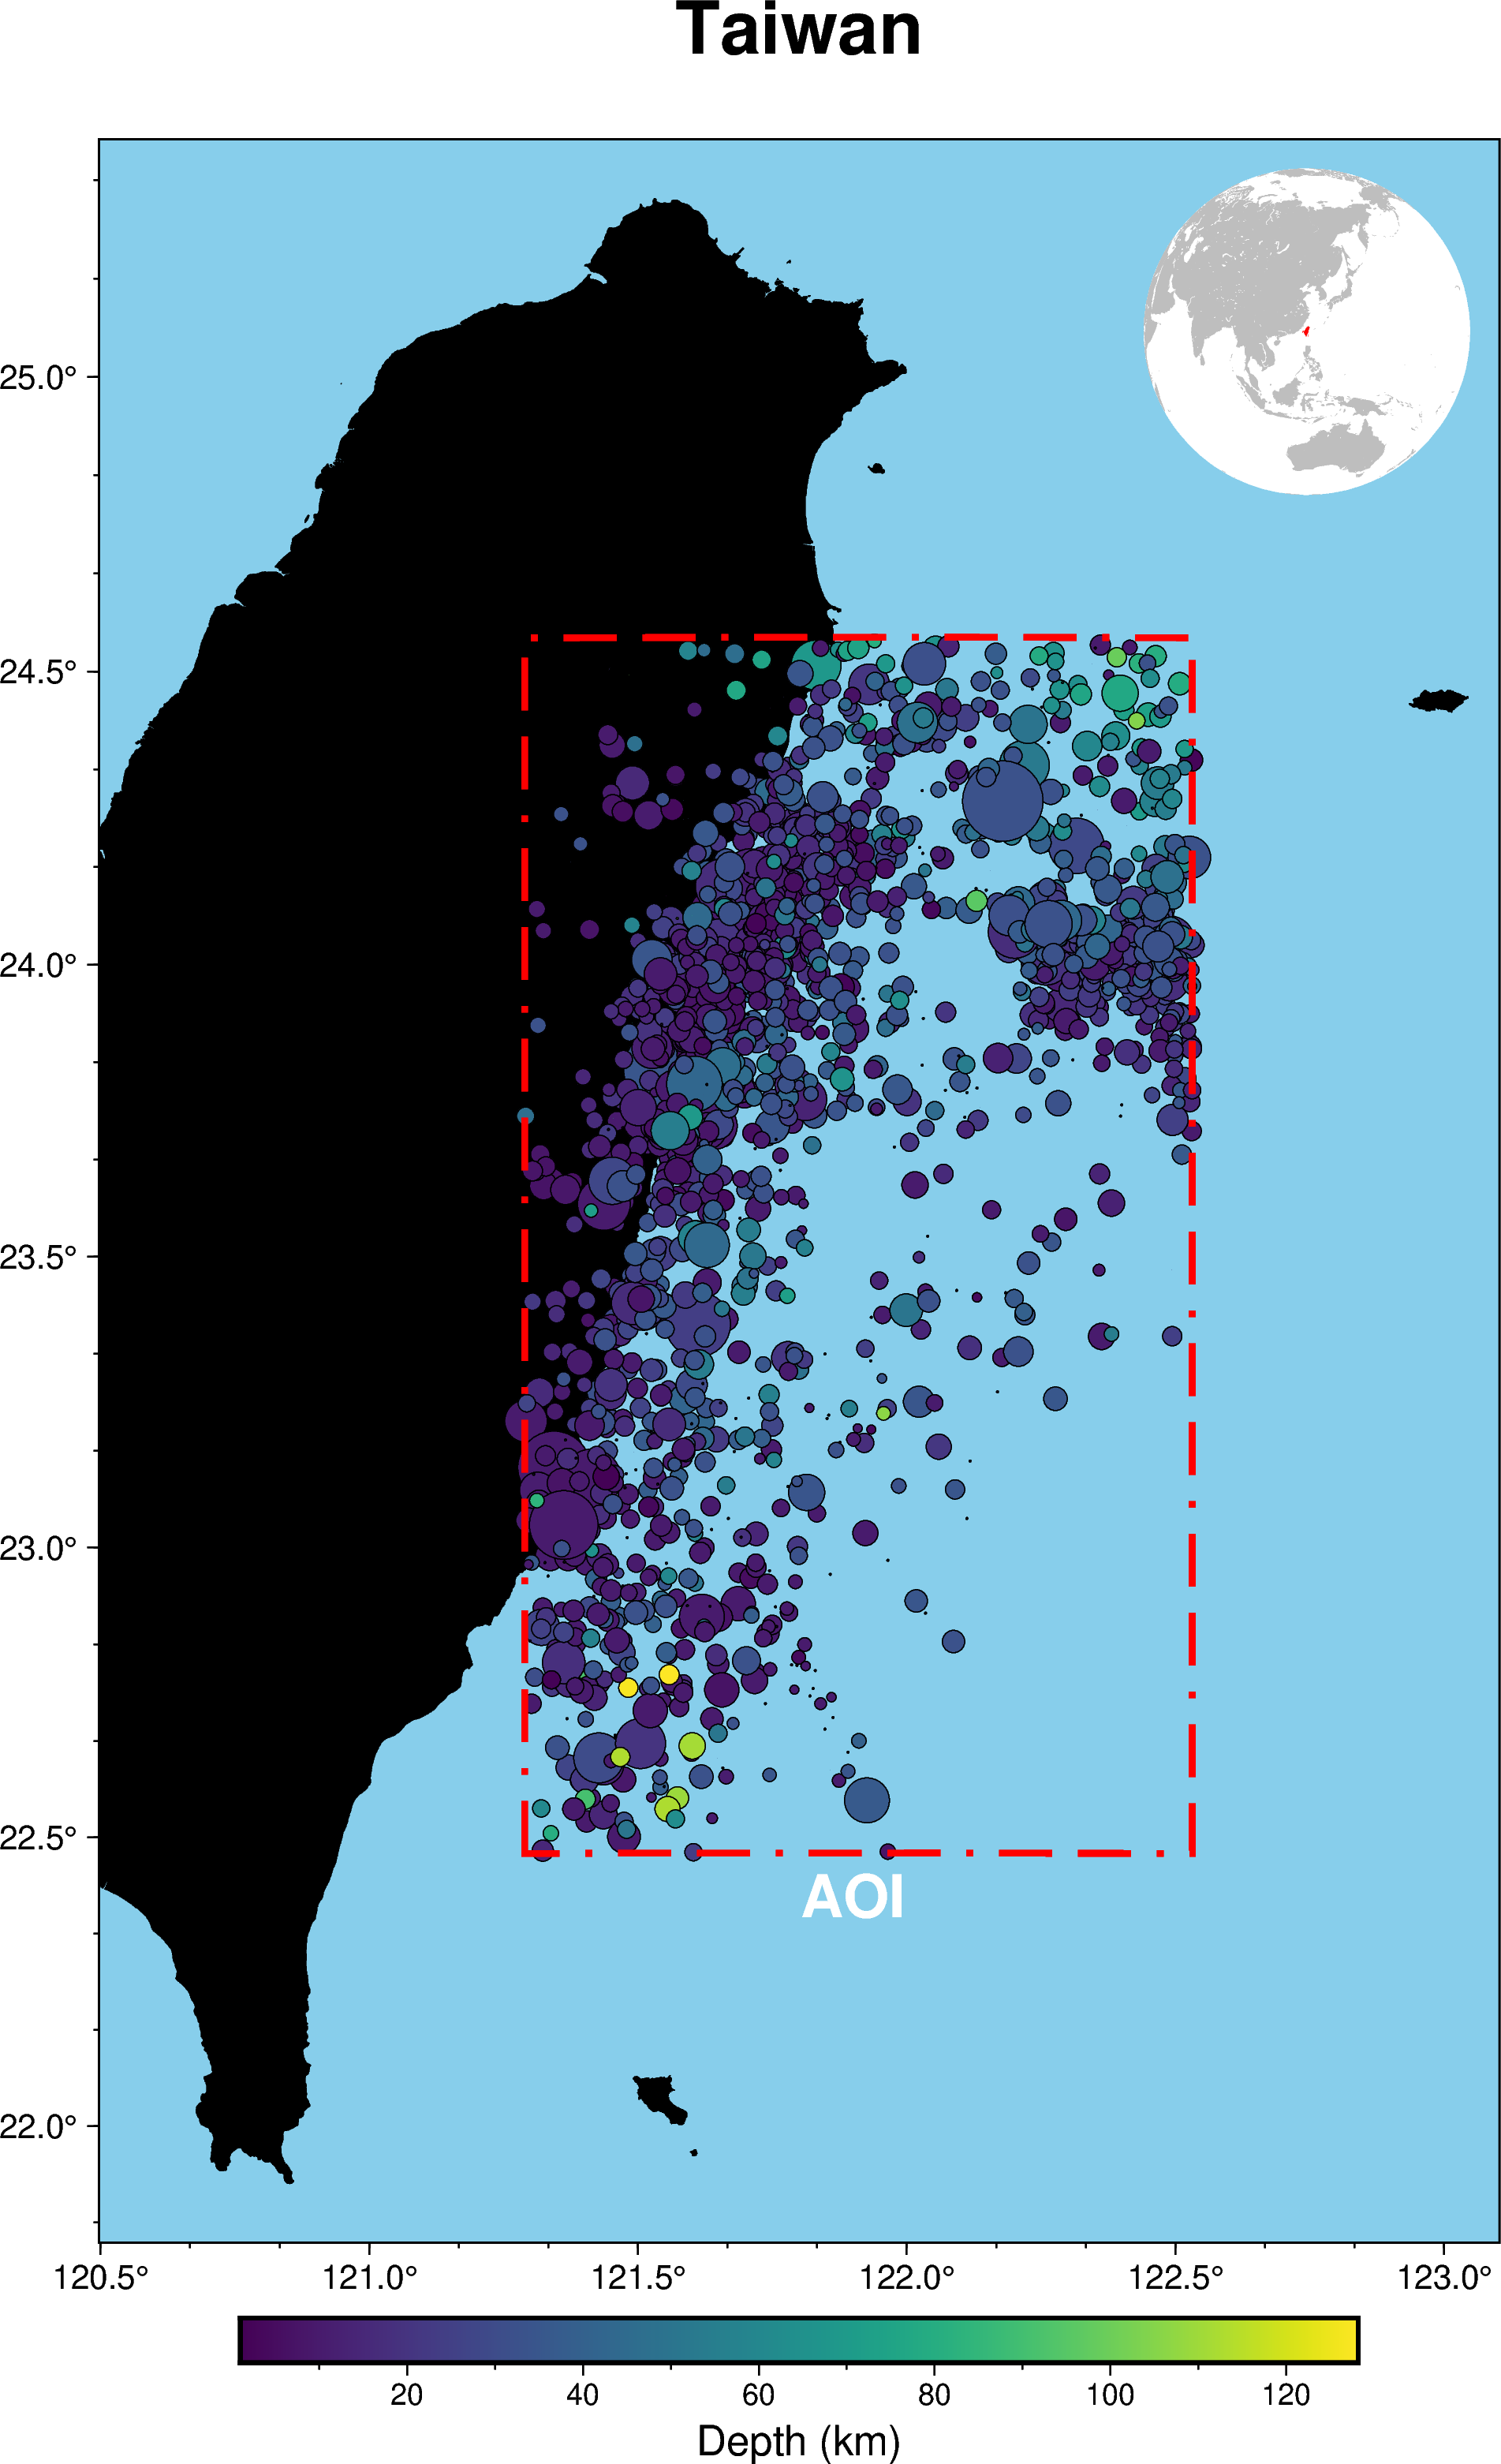

In [ ]:
region = [120.5, 123.1, 21.8, 25.4]
grid = pygmt.datasets.load_earth_relief(resolution='01d', region=region)
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.x', MAP_FRAME_TYPE='plain')
fig.basemap(region=region, projection ='M15c',frame=True)
fig.basemap(frame='+tTaiwan')
fig.coast(land='black', water='skyblue', borders=['2/0.5p,red'])
pygmt.makecpt(cmap="viridis", series=[Taiwan_eq['depth'].min(), Taiwan_eq['depth'].max()])
fig.plot(
    x=Taiwan_eq['longitude'],
    y=Taiwan_eq['latitude'], 
    size=0.02*(1.7**Taiwan_eq['mag']), 
    fill=Taiwan_eq['depth'],
    cmap=True, 
    style='cc',
    pen='black')
fig.colorbar(frame="xaf+lDepth (km)")
fig.plot(
    projection="M15c",
    x=[121.289, 121.289, 122.531, 122.531,121.289],
    y=[22.472, 24.557, 24.557, 22.472, 22.472],
    pen="2p,red,-.-",
)
fig.text(text="AOI", x=121.9, y=22.4, font="18p,Helvetica-Bold,white")
with fig.inset(
    position="jTR+w3.5c+o0.3c",
    margin=0):
    fig.coast(region="g",
              projection="G121/23.5/3.5c",
              land="gray",
              water="white",
              dcw="TW+gred"
    )
fig.show()

In [ ]:
Taiwan_big_eq = Taiwan_eq[Taiwan_eq['mag'] >= 6.0]

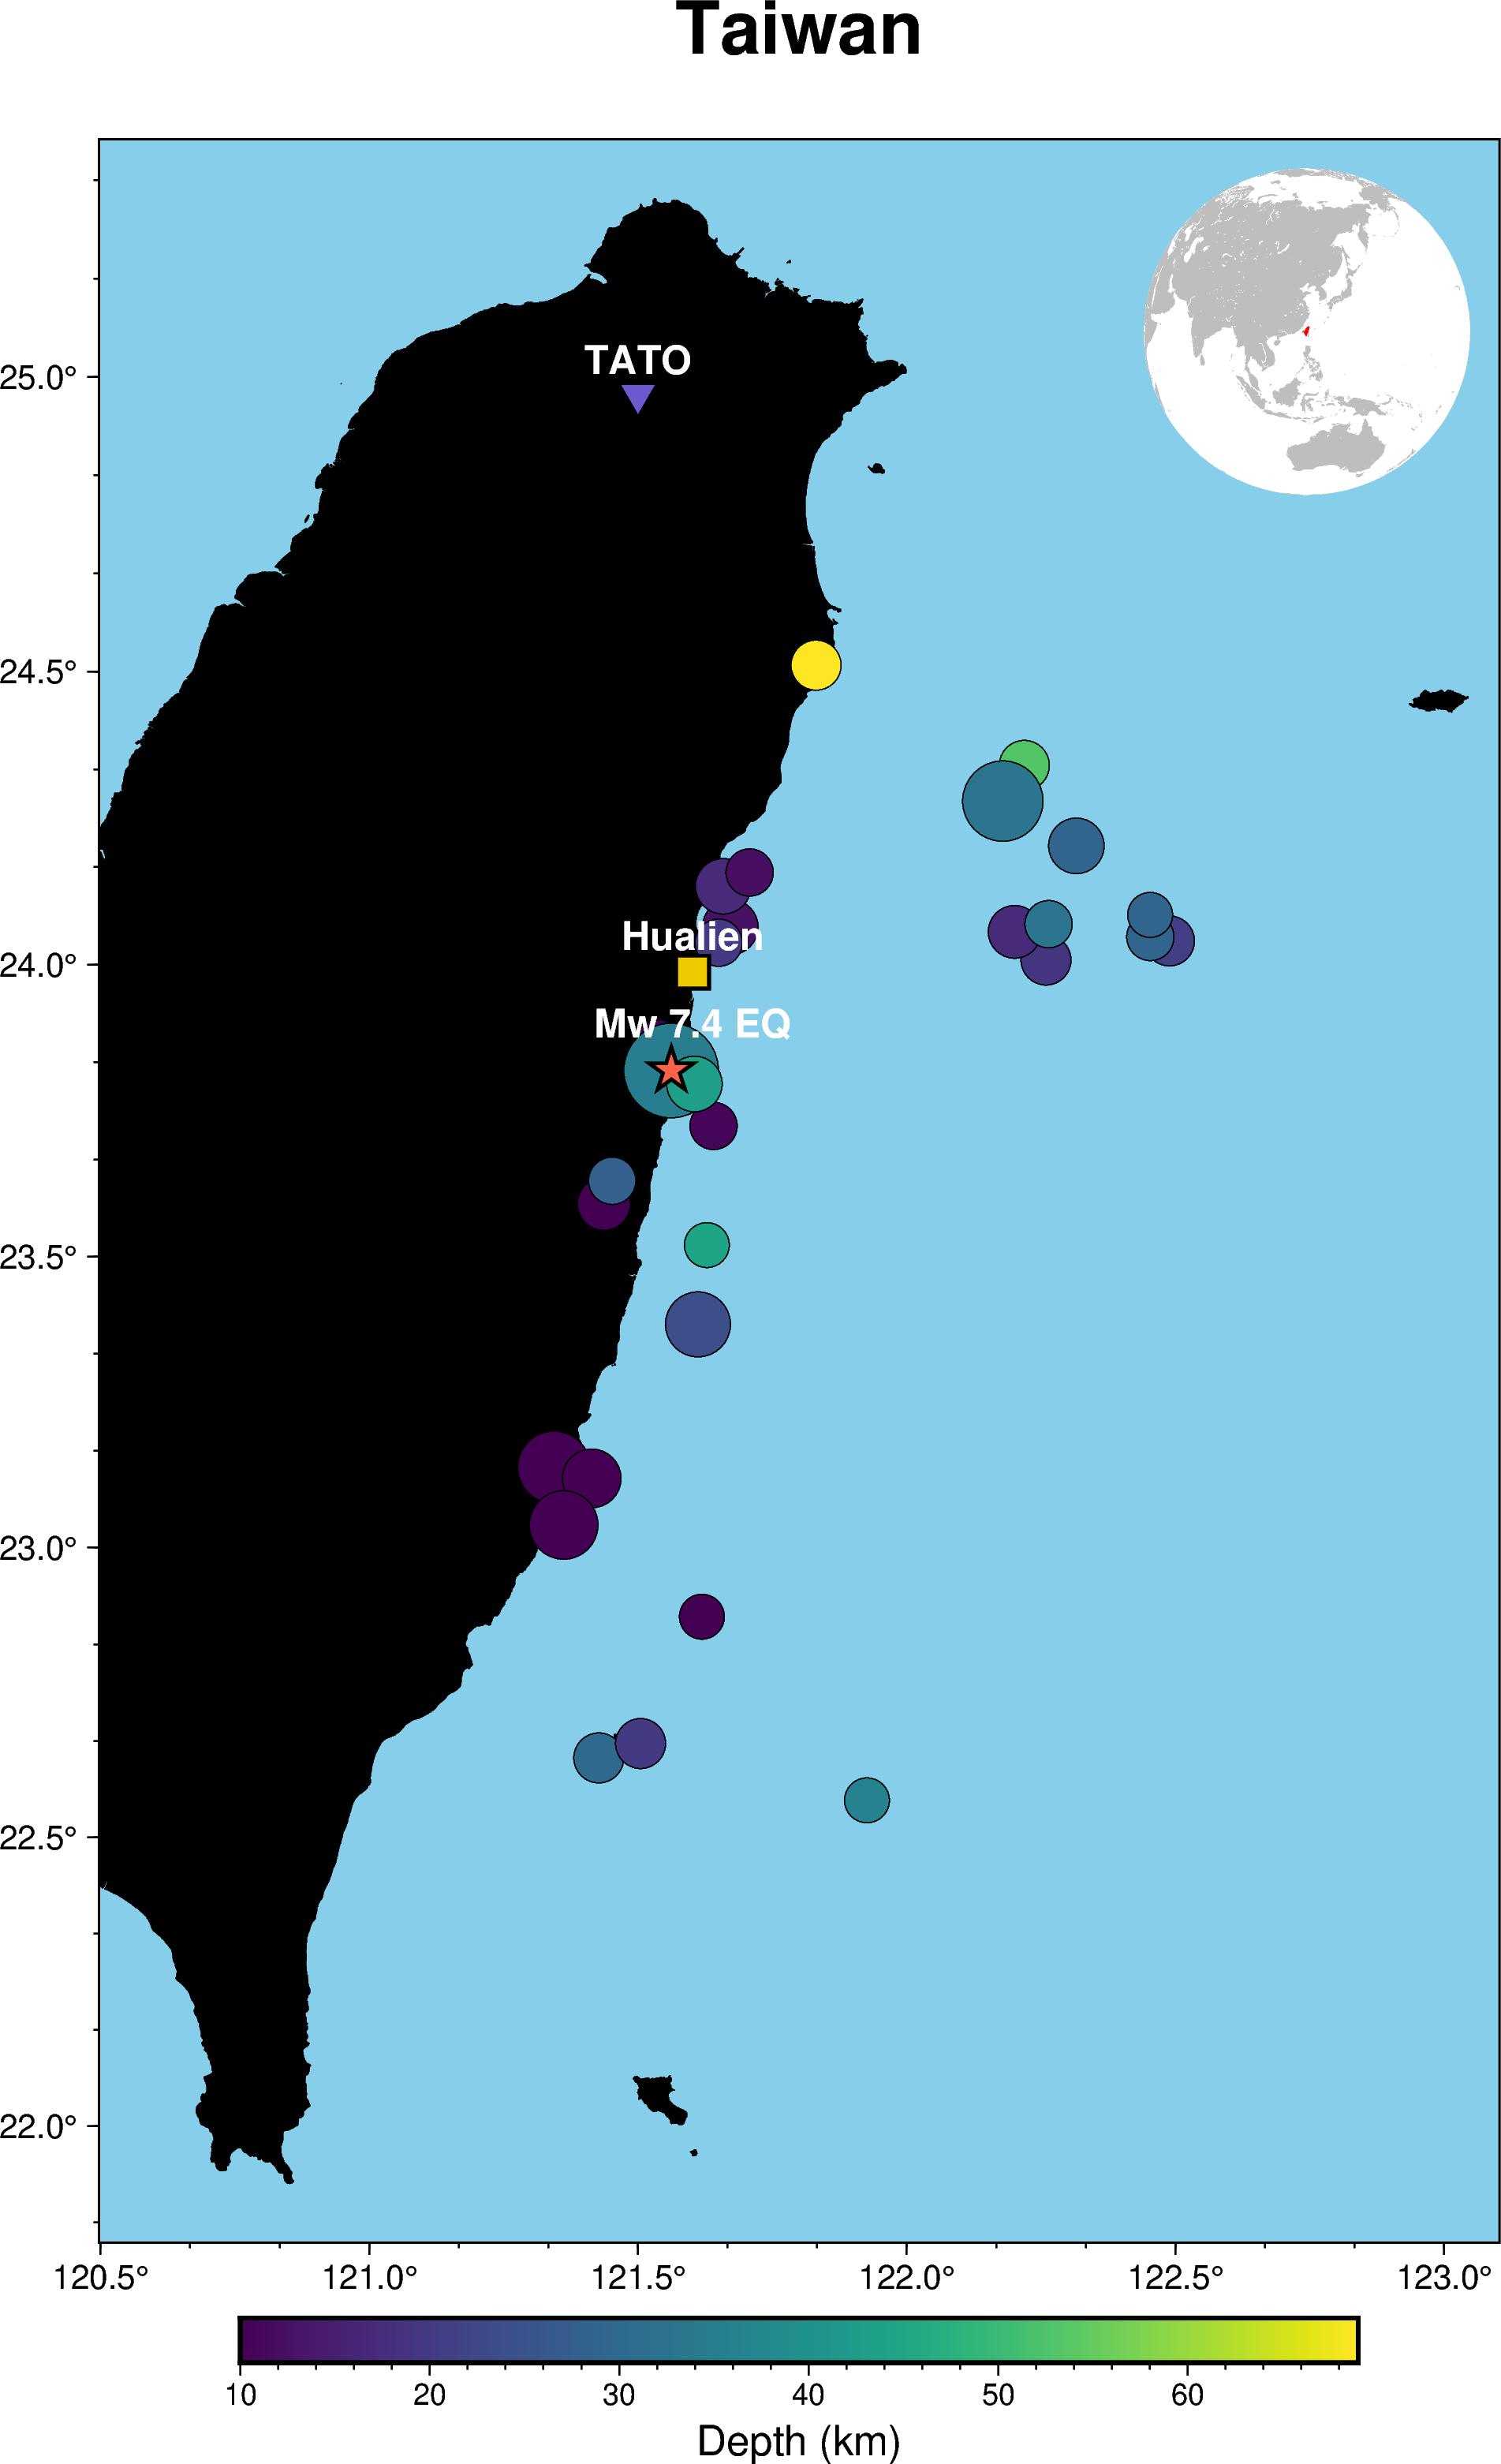

In [ ]:
region = [120.5, 123.1, 21.8, 25.4]
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP='ddd.x', MAP_FRAME_TYPE='plain')
fig.basemap(region=region, projection ='M15c',frame=True)
fig.basemap(frame='+tTaiwan')
fig.coast(land='black', water='skyblue', borders=['2/0.5p,red'])
pygmt.makecpt(cmap="viridis", series=[Taiwan_big_eq['depth'].min(), Taiwan_big_eq['depth'].max()])
fig.plot(
    x=Taiwan_big_eq['longitude'],
    y=Taiwan_big_eq['latitude'], 
    size=0.02*(1.7**Taiwan_big_eq['mag']), 
    fill=Taiwan_big_eq['depth'],
    cmap=True, 
    style='cc',
    pen='black')
fig.colorbar(frame="xaf+lDepth (km)")
# fig.plot(
#     projection="M15c",
#     x=[121.289, 121.289, 122.531, 122.531,121.289],
#     y=[22.472, 24.557, 24.557, 22.472, 22.472],
#     pen="2p,red,-.-",
# )
#fig.text(text="AOI", x=121.9, y=22.4, font="18p,Helvetica-Bold,white")
with fig.inset(
    position="jTR+w3.5c+o0.3c",
    margin=0):
    fig.coast(region="g",
              projection="G121/23.5/3.5c",
              land="gray",
              water="white",
              dcw="TW+gred"
    )

fig.plot(x=121.50, y=24.97, style="i0.5c", pen="1p,black", fill="slateblue")
fig.text(text="TATO",x=121.50, y=25.03, font='12p,Helvetica-Bold,white')
fig.plot(x=121.6016, y=23.9872, style="s0.5c", pen="1p,black", fill="gold2")
fig.text(text="Hualien",x=121.6016, y=24.05, font='12p,Helvetica-Bold,white')
fig.plot(x=121.562, y=23.819, style="a0.5c", pen="1p,black", fill="tomato")
fig.text(text="Mw 7.4 EQ",x=121.6016, y=23.9, font='12p,Helvetica-Bold,white')
fig.show()

In [ ]:
ffm = gpd.read_file('https://raw.githubusercontent.com/Benz-Poobua/Hualien-Earthquake-analysis/ff434a25df44d73b76bdc1c0b17020102bb844e2/FFM.geojson')
ffm.head()

,fill,fill-opacity,rake,rise,sf_moment,slip,stroke-width,trup,x==ew,y==ns,geometry
0,#FEF9F9,1,66.5765,15.0,3.170000e+17,0.2104,1.5,25.5287,-31.6365,-17.0342,"POLYGON Z ((121.24590 23.64470 2150.13166, 121..."
1,#FCFCCB,1,61.5553,6.0,7.820000e+17,0.5188,1.5,23.9267,-28.2825,-10.7432,"POLYGON Z ((121.27610 23.70130 2150.13166, 121..."
2,#FED698,1,61.3031,15.0,1.260000e+18,0.8360,1.5,22.4785,-24.9285,-4.4522,"POLYGON Z ((121.30610 23.75790 2150.13166, 121..."
3,#FDDB9D,1,61.3538,13.5,1.200000e+18,0.7969,1.5,21.2773,-21.5745,1.8388,"POLYGON Z ((121.33630 23.81450 2150.13166, 121..."
4,#FCF5B7,1,61.4647,15.0,9.620000e+17,0.6381,1.5,20.6000,-18.2205,8.1298,"POLYGON Z ((121.36650 23.87120 2150.13166, 121..."


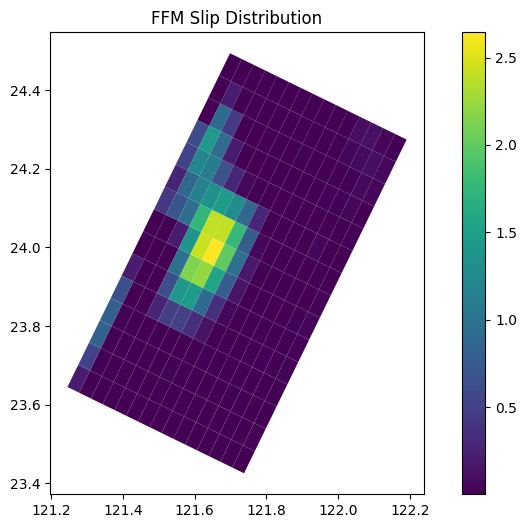

In [ ]:
# Read the GeoJSON file
ffm = gpd.read_file('https://raw.githubusercontent.com/Benz-Poobua/Hualien-Earthquake-analysis/ff434a25df44d73b76bdc1c0b17020102bb844e2/FFM.geojson')

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 6))
ffm.plot(column='slip', cmap='viridis', legend=True, ax=ax)

# Set plot title
plt.title('FFM Slip Distribution')

# Show plot
plt.show()


In [ ]:
fig = pygmt.Figure()


### Tide Gauge data

In [ ]:
# metadata of stations

# Taiwan
thua_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=thua')[8]
tshi_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=tshi')[8]
thep_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=thep')[8]
txig_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=txig')[8]
tsua_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=tsua')[8]
twus_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=twus')[8]

# Japan
ishig_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=ishig')[8]
naha_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=naha')[8]

#Philippines
curri_meta = pd.read_html('http://www.ioc-sealevelmonitoring.org/station.php?code=curri')[8]

In [ ]:
# period: 2024-04-03 (day)
# remove outliers and spikes
# absolute level (as received) or sealevel

# Taiwan
thua1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=thua&output=tab&period=1&endtime=2024-04-03', header=0)[0]
thua1["Time (UTC)"] = pd.to_datetime(thua1["Time (UTC)"])
thua2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=thua&output=tab&period=1&endtime=2024-04-04', header=0)[0]
thua2["Time (UTC)"] = pd.to_datetime(thua2["Time (UTC)"])
thua = pd.concat([thua1, thua2])
thua.reset_index(drop=True, inplace=True)

tshi1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=tshi&output=tab&period=1&endtime=2024-04-03', header=0)[0]
tshi1["Time (UTC)"] = pd.to_datetime(tshi1["Time (UTC)"])
tshi2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=tshi&output=tab&period=1&endtime=2024-04-04', header=0)[0]
tshi2["Time (UTC)"] = pd.to_datetime(tshi2["Time (UTC)"])
tshi = pd.concat([tshi1, tshi2])
tshi.reset_index(drop=True, inplace=True)

thep1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=thep&output=tab&period=1&endtime=2024-04-03', header=0)[0]
thep1["Time (UTC)"] = pd.to_datetime(thep1["Time (UTC)"])
thep2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=thep&output=tab&period=1&endtime=2024-04-04', header=0)[0]
thep2["Time (UTC)"] = pd.to_datetime(thep2["Time (UTC)"])
thep = pd.concat([thep1, thep2])
thep.reset_index(drop=True, inplace=True)

txig1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=txig&output=tab&period=1&endtime=2024-04-03', header=0)[0]
txig1["Time (UTC)"] = pd.to_datetime(txig1["Time (UTC)"])
txig2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=txig&output=tab&period=1&endtime=2024-04-04', header=0)[0]
txig2["Time (UTC)"] = pd.to_datetime(txig2["Time (UTC)"])
txig = pd.concat([txig1, txig2])
txig.reset_index(drop=True, inplace=True)

tsua1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=tsua&output=tab&period=1&endtime=2024-04-03', header=0)[0]
tsua1["Time (UTC)"] = pd.to_datetime(tsua1["Time (UTC)"])
tsua2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=tsua&output=tab&period=1&endtime=2024-04-04', header=0)[0]
tsua2["Time (UTC)"] = pd.to_datetime(tsua2["Time (UTC)"])
tsua = pd.concat([tsua1, tsua2])
tsua.reset_index(drop=True, inplace=True)

twus1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=twus&output=tab&period=1&endtime=2024-04-03', header=0)[0]
twus1["Time (UTC)"] = pd.to_datetime(twus1["Time (UTC)"])
twus2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=twus&output=tab&period=1&endtime=2024-04-04', header=0)[0]
twus2["Time (UTC)"] = pd.to_datetime(twus2["Time (UTC)"])
twus = pd.concat([twus1, twus2])
twus.reset_index(drop=True, inplace=True)

#--------------------------------------------#
# Japan
ishig1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=ishig&output=tab&period=1&endtime=2024-04-03', header=0)[0]
ishig1["Time (UTC)"] = pd.to_datetime(ishig1["Time (UTC)"])
ishig2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=ishig&output=tab&period=1&endtime=2024-04-04', header=0)[0]
ishig2["Time (UTC)"] = pd.to_datetime(ishig2["Time (UTC)"])
ishig = pd.concat([ishig1, ishig2])
ishig.reset_index(drop=True, inplace=True)

naha1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=naha&output=tab&period=1&endtime=2024-04-03', header=0)[0]
naha1["Time (UTC)"] = pd.to_datetime(naha1["Time (UTC)"])
naha2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=naha&output=tab&period=1&endtime=2024-04-04', header=0)[0]
naha2["Time (UTC)"] = pd.to_datetime(naha2["Time (UTC)"])
naha = pd.concat([naha1, naha2])
naha.reset_index(drop=True, inplace=True)

# Philippines
curri1 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=curri&output=tab&period=1&endtime=2024-04-03', header=0)[0]
curri1["Time (UTC)"] = pd.to_datetime(curri1["Time (UTC)"])
curri2 = pd.read_html('https://www.ioc-sealevelmonitoring.org/bgraph.php?code=curri&output=tab&period=1&endtime=2024-04-04', header=0)[0]
curri2["Time (UTC)"] = pd.to_datetime(curri2["Time (UTC)"])
curri = pd.concat([curri1, curri2])
curri = curri[['Time (UTC)', 'rad(m)']]
curri.dropna(inplace=True)
curri.reset_index(drop=True, inplace=True)

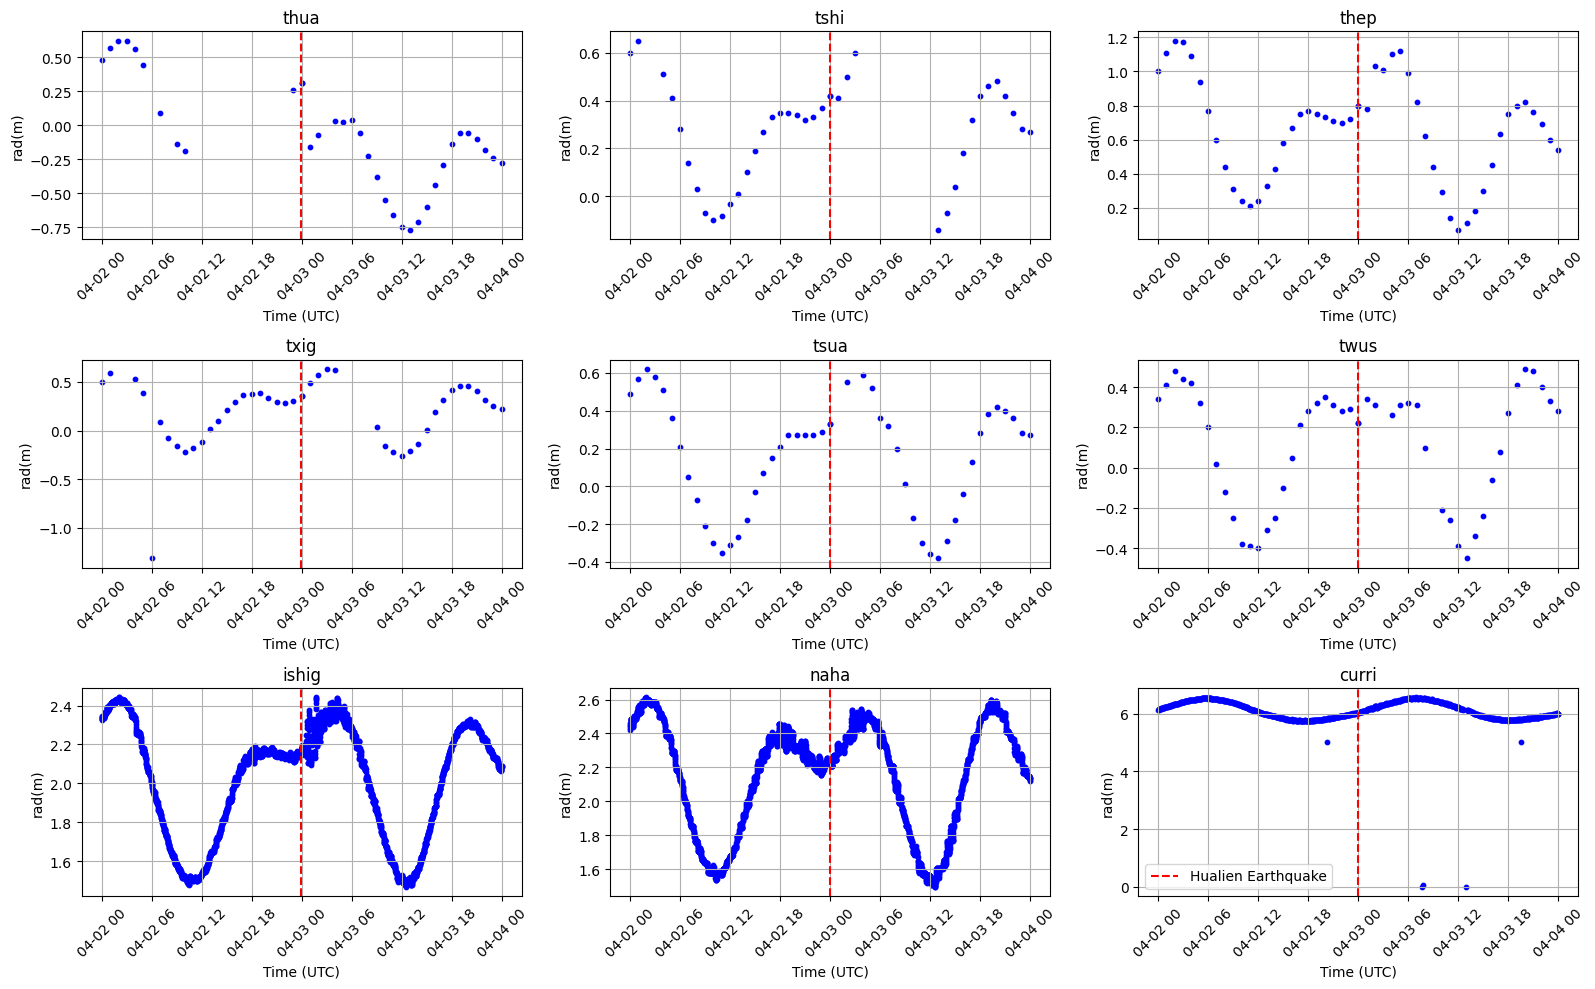

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(16, 10))

# Convert event time to datetime object
event_time = pd.to_datetime('2024-04-02 23:58:12')

locations = [(thua, 'thua'), (tshi, 'tshi'), (thep, 'thep'), (txig, 'txig'), (tsua, 'tsua'), (twus, 'twus'), (ishig, 'ishig'), (naha, 'naha'), (curri, 'curri')]
# Plot data for each location
for i, (data, location) in enumerate(locations):
    row = i // 3
    col = i % 3
    axs[row, col].scatter(data['Time (UTC)'], data['rad(m)'], marker='o', color='blue', s=10)
    axs[row, col].set_title(location)
    axs[row, col].tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    axs[row, col].set_xlabel('Time (UTC)')
    axs[row, col].set_ylabel('rad(m)')
    axs[row, col].grid(True)

    #axs[row, col].set_ylim(-0.8, 1.3)
    axs[row, col].axvline(x=event_time, color='red', linestyle='--', label='Hualien Earthquake')

# Add legend
axs[-1, 2].legend(loc='lower left')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
def filtered_tidegauge(df, df_meta, ax):
    starttime_tg = UTCDateTime(df["Time (UTC)"].iloc[0])
    endtime_tg = UTCDateTime(df["Time (UTC)"].iloc[-1])
    sealevel = df["rad(m)"].to_numpy()
    length = len(df)
    tr = obspy.core.Trace(data=sealevel)   
    tr.stats.network = "IU"
    tr.stats.station = df_meta["Station metadata.1"][df_meta[df_meta['Station metadata'].str.match('Code')].index[0]].upper()
    tr.stats.delta = (endtime_tg - starttime_tg) / (length-1)
    tr.stats.starttime = starttime_tg
    ftr = tr.copy()
    ftr.trim(starttime=t0_utc, endtime=t0_utc+60*60*4)
    ftr.filter(type="highpass", freq=3.5e-5, zerophase=True)
    t = np.linspace(0, 4, ftr.stats.npts)
    ax.plot(t, ftr.data, 'b')
    ax.set_xlim(t[0], t[-1])
    ax.set_title("{}".format(df_meta["Station metadata.1"][df_meta[df_meta['Station metadata'].str.match('Location')].index[0]])) 
    return ax

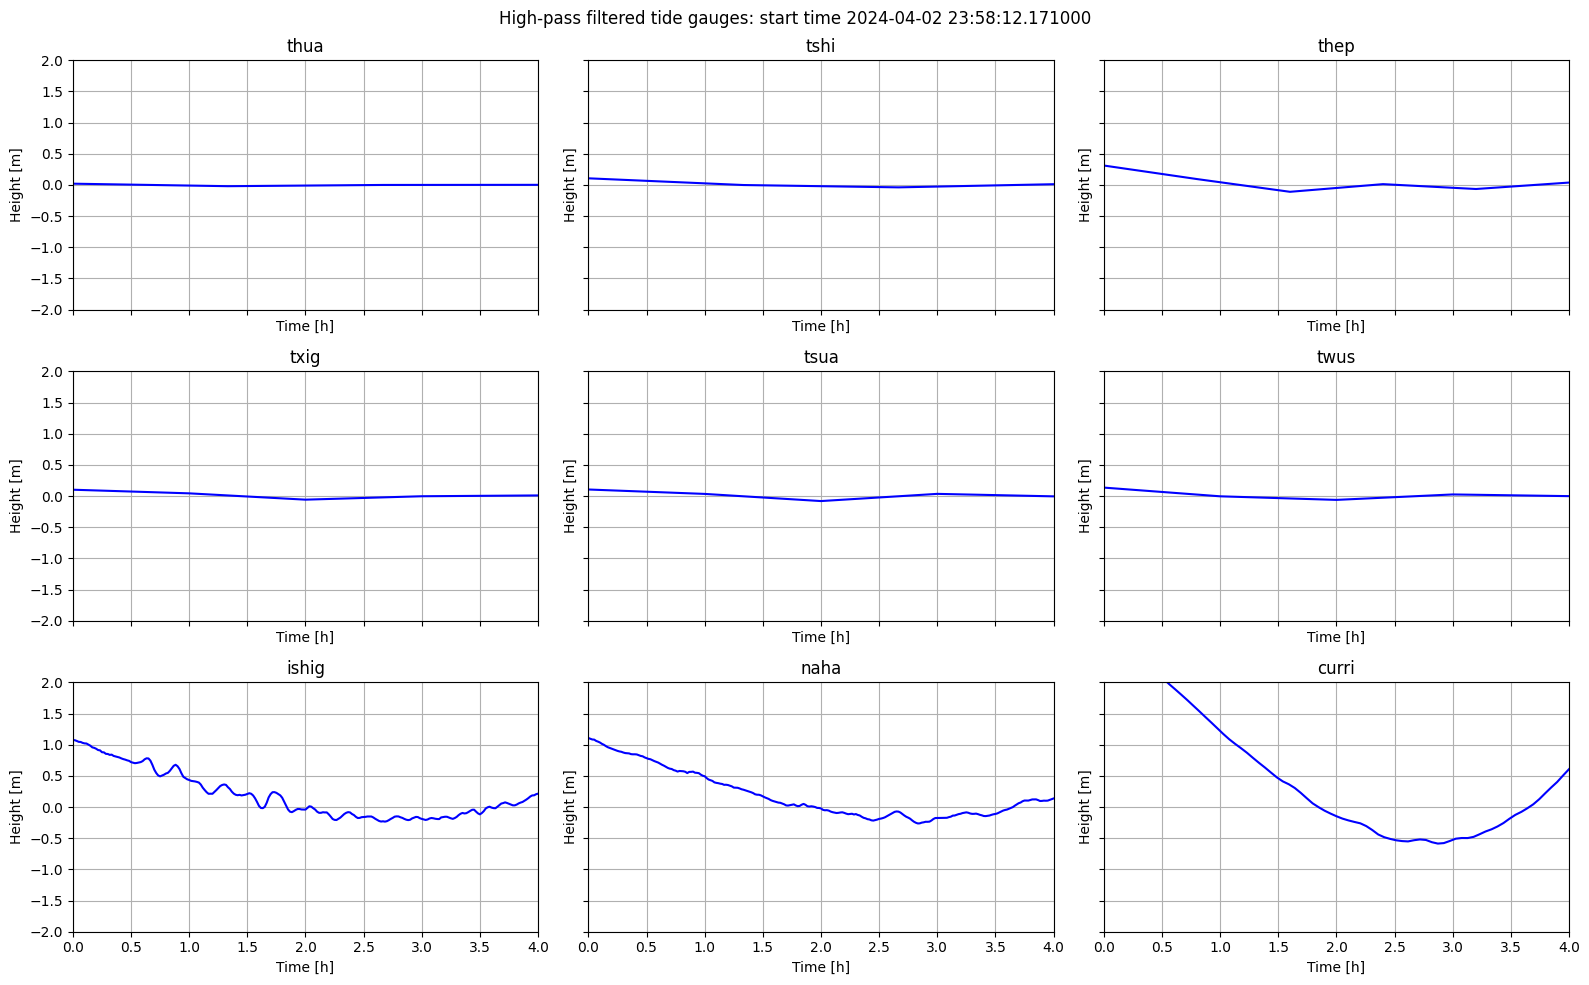

In [ ]:
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(16, 10))
fig.suptitle("High-pass filtered tide gauges: start time {}".format(t0_utc.datetime))

# Set y-axis limits for the first subplot
axs[0, 0].set_ylim(-2, 2)

locations = [(thua, thua_meta, 'thua'), (tshi, tshi_meta, 'tshi'), (thep, thep_meta, 'thep'), (txig, txig_meta, 'txig'), (tsua, tsua_meta, 'tsua'), (twus, twus_meta, 'twus'), (ishig, ishig_meta, 'ishig'), (naha, naha_meta, 'naha'), (curri, curri_meta, 'curri')]

# Call filtered_tidegauge function for each location
for i, (data, meta, location) in enumerate(locations):
    row = i // 3
    col = i % 3
    filtered_tidegauge(data, meta, axs[row, col])
    axs[row, col].set_title(location)
    axs[row, col].set_xlabel('Time [h]')
    axs[row, col].set_ylabel('Height [m]')
    axs[row, col].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

**TO DO**
1. Stack sealevel for ishig and naha for 5 years
2. Calculate the residuals 
3. (optional) calculate the cross-correlation
4. Import InSAR to the map